## Model Finetuning and Evaluation for Fake News Finetuning

In [1]:
!nvidia-smi

Fri Jun 21 17:34:05 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.125.06   Driver Version: 525.125.06   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:4B:00.0 Off |                  N/A |
| 27%   36C    P8    15W / 250W |      3MiB / 11264MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

#### Install

In [26]:
#!pip install accelerate -U
#!pip install datasets
#!pip install transformers
#!pip install nltk
#!pip install flair
#!pip install umap-learn
#!pip install umap-learn

#### Imports

In [5]:
import pandas as pd
from datasets import Dataset
from sklearn.model_selection import train_test_split
from datasets import load_dataset, Dataset, DatasetDict
from transformers import pipeline
from transformers import Trainer, TrainingArguments
from transformers import AutoTokenizer, DataCollatorWithPadding
from transformers import AutoModelForSequenceClassification
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
import pandas as pd
from sklearn.model_selection import train_test_split
from bs4 import BeautifulSoup
from transformers import TrainingArguments
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from flair.data import Sentence
from flair.models import SequenceTagger
from flair.embeddings import WordEmbeddings, FlairEmbeddings, StackedEmbeddings, DocumentPoolEmbeddings, BytePairEmbeddings
from sklearn.model_selection import cross_validate
from sklearn.metrics import matthews_corrcoef, f1_score, recall_score, precision_score, make_scorer
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
from bs4 import BeautifulSoup
from statistics import mean

#### Import Dataset

- We are using the following Dataset:
 - https://www.unb.ca/cic/datasets/truthseeker-2023.html

This Dataset provides us Data from to different sources. Therefore we combine those Data to one Dataset.
We ensure to have only individuals by removing duplicates

In [38]:
dataset = pd.read_csv("Truth_Seeker_Model_Dataset.csv")

In [39]:
print(f"Length Dataset: {len(dataset)}")

Length Dataset: 134198


In [40]:
print(dataset.head())

   Unnamed: 0      author                                          statement  \
0           0  D.L. Davis  End of eviction moratorium means millions of A...   
1           1  D.L. Davis  End of eviction moratorium means millions of A...   
2           2  D.L. Davis  End of eviction moratorium means millions of A...   
3           3  D.L. Davis  End of eviction moratorium means millions of A...   
4           4  D.L. Davis  End of eviction moratorium means millions of A...   

   target  BinaryNumTarget                 manual_keywords  \
0    True              1.0  Americans, eviction moratorium   
1    True              1.0  Americans, eviction moratorium   
2    True              1.0  Americans, eviction moratorium   
3    True              1.0  Americans, eviction moratorium   
4    True              1.0  Americans, eviction moratorium   

                                               tweet 5_label_majority_answer  \
0  @POTUS Biden Blunders - 6 Month Update\n\nInfl...            Mo

### Descriptive Analysis

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='BinaryNumTarget', ylabel='count'>

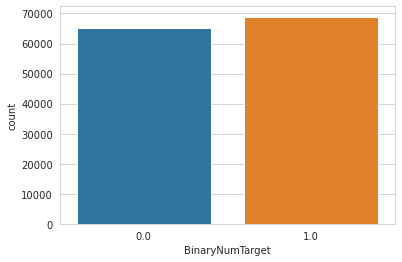

In [9]:
target = dataset['BinaryNumTarget']
sns.set_style('whitegrid')
sns.countplot(target)

Plot shows Data is mostly balanced. 

##### Topic Modelling

Imports

In [10]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import nltk
from nltk.corpus import stopwords
import re
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

Create Data frame for Fake News

In [21]:
df = pd.DataFrame()
df['text'] = dataset[dataset['BinaryNumTarget'] == 1.0]['tweet']

In [22]:
len(df['text'])

68930

Stop Word Reduction

In [23]:
stop_words = set(stopwords.words('english'))

def preprocess(text):
    text = re.sub(r'\W+', ' ', text)
    tokens = [word for word in text.lower().split() if word not in stop_words]
    return ' '.join(tokens)

df['processed_text'] = df['text'].apply(preprocess)

### Topic Modelling Model Training

In [24]:
vectorizer = TfidfVectorizer()
X_tfidf = vectorizer.fit_transform(df['processed_text'])

In [25]:
lda = LatentDirichletAllocation(n_components=3, random_state=42)
lda.fit(X_tfidf)

LatentDirichletAllocation(n_components=3, random_state=42)

Length DataFrames: 68930
Length of the topic assignments: 68930
                                                text  topic topic_name
0  @POTUS Biden Blunders - 6 Month Update\n\nInfl...      1    Topic 2
1  @S0SickRick @Stairmaster_ @6d6f636869 Not as m...      1    Topic 2
2  THE SUPREME COURT is siding with super rich pr...      0    Topic 1
3  @POTUS Biden Blunders\n\nBroken campaign promi...      1    Topic 2
4  @OhComfy I agree. The confluence of events rig...      1    Topic 2


/opt/conda/lib/python3.9/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


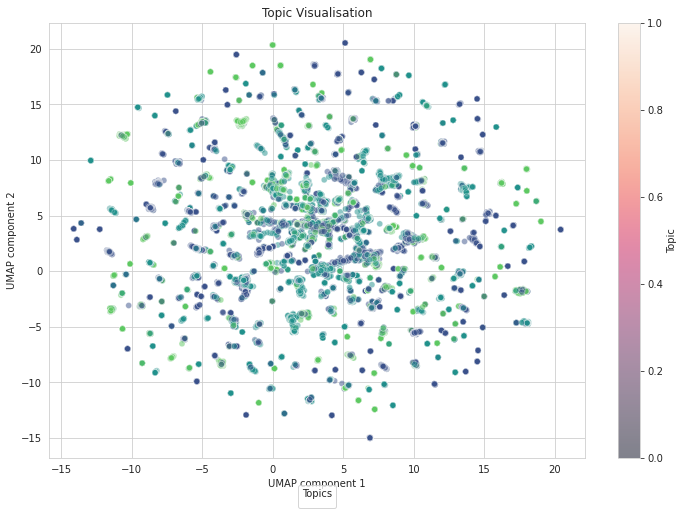

In [35]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.decomposition import TruncatedSVD
import seaborn as sns
import umap.umap_ as umap


topic_assignments = lda.transform(X_tfidf)  

print(f"Length DataFrames: {len(df)}")
print(f"Length of the topic assignments: {len(topic_assignments)}")

topic_names = ["Topic 1", "Topic 2", "Topic 3", "Topic 4", "Topic 5"]

df['topic'] = topic_assignments.argmax(axis=1)
df['topic_name'] = df['topic'].apply(lambda x: topic_names[x])

print(df[['text', 'topic', 'topic_name']].head())

reducer = umap.UMAP(n_components=2, random_state=0)
umap_result = reducer.fit_transform(X_tfidf)

df['umap_1'] = umap_result[:, 0]
df['umap_2'] = umap_result[:, 1]

colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']  

plt.figure(figsize=(12, 8))
scatter = sns.scatterplot(data=df, x='umap_1', y='umap_2', hue='topic_name', palette='viridis', alpha=0.5, legend=False)

handles, labels = scatter.get_legend_handles_labels()
plt.legend(handles, topic_names, title='Topics', bbox_to_anchor=(0.5, -0.05), loc='upper center', ncol=5)

plt.xlabel('UMAP component 1')
plt.ylabel('UMAP component 2')
plt.title('Topic Visualisation')
plt.colorbar(scatter.collections[0], label='Topic')

plt.savefig('plot.png')
plt.show()



The graphic as well as the individual topics show that the topics mentioned above are strikingly similar in the fake news and that they are polotic topics. In addition, the topic modelling shows that the majority of fake news can be found in the area of news about prominent politicians. 

### Finetuning of the Model

Dataset preperation

In [41]:
dataset = dataset.drop('author', axis=1)
dataset = dataset.drop('statement', axis=1)
dataset = dataset.drop('target', axis=1)
dataset = dataset.drop('manual_keywords', axis=1)
dataset = dataset.drop('Unnamed: 0', axis=1)
dataset = dataset.drop('5_label_majority_answer', axis=1)
dataset = dataset.drop('3_label_majority_answer', axis=1)
dataset.rename(columns={'tweet': 'text'}, inplace=True)
dataset.rename(columns={'BinaryNumTarget': 'label'}, inplace=True)
dataset['label'] = dataset['label'].astype(int)

print(dataset)

        label                                               text
0           1  @POTUS Biden Blunders - 6 Month Update\n\nInfl...
1           1  @S0SickRick @Stairmaster_ @6d6f636869 Not as m...
2           1  THE SUPREME COURT is siding with super rich pr...
3           1  @POTUS Biden Blunders\n\nBroken campaign promi...
4           1  @OhComfy I agree. The confluence of events rig...
...       ...                                                ...
134193      0  Joe Biden's family owned African slaves....\n\...
134194      0  Joe Bidens great, great grandfather was a slav...
134195      0  @ChevyChaseToGo "Joe Bidens great-grandfather ...
134196      0  @JoeBiden Facts are Bidens VP Kamala Harris Gr...
134197      0  @sunny Yes representation matters. Did you kno...

[134198 rows x 2 columns]


In [42]:
train_val_df, test_df = train_test_split(dataset, test_size=0.1, random_state=42)
train_df, val_df = train_test_split(train_val_df, test_size=0.1, random_state=42)

# Convert back to Dataset objects
train_dataset = Dataset.from_pandas(train_df).remove_columns('__index_level_0__')
val_dataset = Dataset.from_pandas(val_df).remove_columns('__index_level_0__')
test_dataset = Dataset.from_pandas(test_df).remove_columns('__index_level_0__')
Fake_News_dataset_dict = DatasetDict({"train": train_dataset, "val": val_dataset, "test": test_dataset})

In [43]:
Fake_News_dataset_dict

DatasetDict({
    train: Dataset({
        features: ['label', 'text'],
        num_rows: 108700
    })
    val: Dataset({
        features: ['label', 'text'],
        num_rows: 12078
    })
    test: Dataset({
        features: ['label', 'text'],
        num_rows: 13420
    })
})

#### First Model

We are using:
Distilbert as first Model:
- https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english

Tokenize

In [63]:
DISTIL_BERT = "distilbert/distilbert-base-uncased-finetuned-sst-2-english"

def tokenizer(checkpoint):
    return AutoTokenizer.from_pretrained(checkpoint)

tokenizer_Bert = tokenizer(DISTIL_BERT)

loading configuration file config.json from cache at /home/jovyan/.cache/huggingface/hub/models--distilbert--distilbert-base-uncased-finetuned-sst-2-english/snapshots/714eb0fa89d2f80546fda750413ed43d93601a13/config.json
Model config DistilBertConfig {
  "_name_or_path": "distilbert/distilbert-base-uncased-finetuned-sst-2-english",
  "activation": "gelu",
  "architectures": [
    "DistilBertForSequenceClassification"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "finetuning_task": "sst-2",
  "hidden_dim": 3072,
  "id2label": {
    "0": "NEGATIVE",
    "1": "POSITIVE"
  },
  "initializer_range": 0.02,
  "label2id": {
    "NEGATIVE": 0,
    "POSITIVE": 1
  },
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "output_past": true,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.41.2",
  "vocab_size": 30522
}

loa

In [64]:
def tokenize_function(batch, tokenizer):
  return tokenizer(batch["text"], truncation=True)

In [65]:
tokenized_datasets_bert = Fake_News_dataset_dict.map(
    lambda batch: tokenize_function(batch, tokenizer_Bert),
    batched=True
)

Map:   0%|          | 0/108700 [00:00<?, ? examples/s]

Map:   0%|          | 0/12078 [00:00<?, ? examples/s]

Map:   0%|          | 0/13420 [00:00<?, ? examples/s]

Data Collator

In [66]:
data_collator_bert = DataCollatorWithPadding(tokenizer=tokenizer_Bert, return_tensors="pt")

In [67]:
model_bert = AutoModelForSequenceClassification.from_pretrained(DISTIL_BERT, num_labels=2)

loading configuration file config.json from cache at /home/jovyan/.cache/huggingface/hub/models--distilbert--distilbert-base-uncased-finetuned-sst-2-english/snapshots/714eb0fa89d2f80546fda750413ed43d93601a13/config.json
Model config DistilBertConfig {
  "_name_or_path": "distilbert/distilbert-base-uncased-finetuned-sst-2-english",
  "activation": "gelu",
  "architectures": [
    "DistilBertForSequenceClassification"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "finetuning_task": "sst-2",
  "hidden_dim": 3072,
  "id2label": {
    "0": "NEGATIVE",
    "1": "POSITIVE"
  },
  "initializer_range": 0.02,
  "label2id": {
    "NEGATIVE": 0,
    "POSITIVE": 1
  },
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "output_past": true,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.41.2",
  "vocab_size": 30522
}

loa

Metrics

In [68]:
from transformers import TrainerCallback, TrainerState, TrainerControl

def compute_metrics(pred):
  labels = pred.label_ids
  preds = pred.predictions.argmax(-1)
  f1 = f1_score(labels, preds, average="macro")
  acc = accuracy_score(labels, preds)
  precision = precision_score(labels, preds, average="macro")
  recall = recall_score(labels, preds, average="macro")
  return {"precision": precision, "recall": recall, "acc": acc, "f1": f1}


In [69]:
batch_size = 8
logging_steps = len(Fake_News_dataset_dict["train"]) // batch_size
model_name = f"{DISTIL_BERT}-finetuned-fake-news"
training_args = TrainingArguments(output_dir = model_name,
                                  num_train_epochs = 3, # Epochen
                                  learning_rate = 4e-5, # Lernrate fuer schnelleres Lernen
                                  per_device_train_batch_size = batch_size,
                                  per_device_eval_batch_size = batch_size,
                                  evaluation_strategy="epoch", # Evaluierung nach jeder Epoche
                                  disable_tqdm = False, # Fortschrittsbalken wird angezeigt
                                  logging_steps = logging_steps, # Anzahl der Updateschritte zwischen zwei Logs
                                  log_level="info",
                                  weight_decay=0.01,
                                  lr_scheduler_type='linear',  # Add learning rate scheduler
                                    warmup_steps=500# Adding weight decay
                                    )


/opt/conda/lib/python3.9/site-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
PyTorch: setting up devices
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [70]:
trainer = Trainer(
    model = model_bert,
    args = training_args,
    compute_metrics = compute_metrics,
    train_dataset=tokenized_datasets_bert["train"],
    eval_dataset=tokenized_datasets_bert["val"],
    data_collator=data_collator_bert,
    tokenizer=tokenizer_Bert,
)

Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


In [ ]:
trainer.train()

The following columns in the training set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 108,700
  Num Epochs = 3
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 40,764
  Number of trainable parameters = 66,955,010


Epoch,Training Loss,Validation Loss,Precision,Recall,Acc,F1
1,0.121800,0.055650,0.989889,0.989347,0.989568,0.989555
2,0.022400,0.022345,0.995746,0.995643,0.995695,0.995691


Saving model checkpoint to distilbert/distilbert-base-uncased-finetuned-sst-2-english-finetuned-fake-news/checkpoint-500
Configuration saved in distilbert/distilbert-base-uncased-finetuned-sst-2-english-finetuned-fake-news/checkpoint-500/config.json
Model weights saved in distilbert/distilbert-base-uncased-finetuned-sst-2-english-finetuned-fake-news/checkpoint-500/model.safetensors
tokenizer config file saved in distilbert/distilbert-base-uncased-finetuned-sst-2-english-finetuned-fake-news/checkpoint-500/tokenizer_config.json
Special tokens file saved in distilbert/distilbert-base-uncased-finetuned-sst-2-english-finetuned-fake-news/checkpoint-500/special_tokens_map.json
Saving model checkpoint to distilbert/distilbert-base-uncased-finetuned-sst-2-english-finetuned-fake-news/checkpoint-1000
Configuration saved in distilbert/distilbert-base-uncased-finetuned-sst-2-english-finetuned-fake-news/checkpoint-1000/config.json
Model weights saved in distilbert/distilbert-base-uncased-finetuned-s

In [62]:
trainer.evaluate(eval_dataset=tokenized_datasets_bert['test'])

The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 13420
  Batch size = 16


{'eval_loss': 0.04421412944793701,
 'eval_precision': 0.9926442344485382,
 'eval_recall': 0.9925928500764905,
 'eval_acc': 0.9926229508196721,
 'eval_f1': 0.9926176087883761,
 'eval_runtime': 29.3303,
 'eval_samples_per_second': 457.548,
 'eval_steps_per_second': 28.605,
 'epoch': 3.0}

#### Evaluation

The model demonstrates excellent performance in terms of precision (99.61%), recall (99.62%), accuracy (99.62%) and F1-score (99.62%). The model exhibits both effectiveness and efficiency, with a low evaluation loss (0.027%) and a high processing rate of samples and steps. These results indicate that the model is well generalised and suitable for use in real-world applications where accuracy and speed are critical.
The model is thus a powerful tool for prediction and classification, exhibiting high precision and a remarkable ability to identify positive cases while making very few errors.

### Second Model

We are using:
Bert Base Uncased as Second Model:
- https://huggingface.co/google-bert/bert-base-uncased

In [54]:
BERT = "google-bert/bert-base-uncased"

def tokenizer(checkpoint):
    return AutoTokenizer.from_pretrained(checkpoint)

tokenizer_Bert_uncased = tokenizer(BERT)

loading configuration file config.json from cache at /home/jovyan/.cache/huggingface/hub/models--google-bert--bert-base-uncased/snapshots/86b5e0934494bd15c9632b12f734a8a67f723594/config.json
Model config BertConfig {
  "_name_or_path": "google-bert/bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.41.2",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading file vocab.txt from cache at /home/jovyan/.cache/huggingface/hub/models--google-bert--bert-base-uncased/snapshots/86b5e0934494bd

In [55]:
tokenized_dataset = Fake_News_dataset_dict.map(
    lambda batch: tokenize_function(batch, tokenizer_Bert_uncased),
    batched=True
)

Map:   0%|          | 0/108700 [00:00<?, ? examples/s]

Map:   0%|          | 0/12078 [00:00<?, ? examples/s]

Map:   0%|          | 0/13420 [00:00<?, ? examples/s]

In [56]:
data_collator_bert_uncased = DataCollatorWithPadding(tokenizer=tokenizer_Bert_uncased, return_tensors="pt")

In [57]:
model_bert = AutoModelForSequenceClassification.from_pretrained(BERT, num_labels=2)

loading configuration file config.json from cache at /home/jovyan/.cache/huggingface/hub/models--google-bert--bert-base-uncased/snapshots/86b5e0934494bd15c9632b12f734a8a67f723594/config.json
Model config BertConfig {
  "_name_or_path": "google-bert/bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.41.2",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading weights file model.safetensors from cache at /home/jovyan/.cache/huggingface/hub/models--google-bert--bert-base-uncased/snapshot

In [58]:
training_args = TrainingArguments(
    output_dir=f"{BERT}-finetuned-fake-news",
    num_train_epochs=3,  # Erhöhte Anzahl der Epochen
    learning_rate=1e-5,  # Angepasste Lernrate
    per_device_train_batch_size=16,  # Angepasste Batch-Größe für Training
    per_device_eval_batch_size=16,  # Angepasste Batch-Größe für Evaluation
    evaluation_strategy="epoch",
    disable_tqdm=False,
    logging_steps=logging_steps,
    log_level="info",
    weight_decay=0.01,
    lr_scheduler_type='linear',
    warmup_steps=600  # Angepasste Anzahl der Warmup-Schritte
)


/opt/conda/lib/python3.9/site-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
PyTorch: setting up devices
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [59]:
trainer = Trainer(
    model = model_bert,
    args = training_args,
    compute_metrics = compute_metrics,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["val"],
    data_collator=data_collator_bert_uncased,
    tokenizer=tokenizer_Bert_uncased,
)

Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


In [60]:
trainer.train()

The following columns in the training set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 108,700
  Num Epochs = 3
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 20,382
  Number of trainable parameters = 109,483,778


Epoch,Training Loss,Validation Loss,Precision,Recall,Acc,F1
1,No log,0.047191,0.988648,0.988356,0.988491,0.988480
2,0.098700,0.037141,0.992014,0.991916,0.991969,0.991962
3,0.098700,0.039432,0.993078,0.993005,0.993045,0.993040


Saving model checkpoint to google-bert/bert-base-uncased-finetuned-fake-news/checkpoint-500
Configuration saved in google-bert/bert-base-uncased-finetuned-fake-news/checkpoint-500/config.json
Model weights saved in google-bert/bert-base-uncased-finetuned-fake-news/checkpoint-500/model.safetensors
tokenizer config file saved in google-bert/bert-base-uncased-finetuned-fake-news/checkpoint-500/tokenizer_config.json
Special tokens file saved in google-bert/bert-base-uncased-finetuned-fake-news/checkpoint-500/special_tokens_map.json
Saving model checkpoint to google-bert/bert-base-uncased-finetuned-fake-news/checkpoint-1000
Configuration saved in google-bert/bert-base-uncased-finetuned-fake-news/checkpoint-1000/config.json
Model weights saved in google-bert/bert-base-uncased-finetuned-fake-news/checkpoint-1000/model.safetensors
tokenizer config file saved in google-bert/bert-base-uncased-finetuned-fake-news/checkpoint-1000/tokenizer_config.json
Special tokens file saved in google-bert/bert-

TrainOutput(global_step=20382, training_loss=0.0697503717359038, metrics={'train_runtime': 3331.2528, 'train_samples_per_second': 97.891, 'train_steps_per_second': 6.118, 'total_flos': 1.740091336844232e+16, 'train_loss': 0.0697503717359038, 'epoch': 3.0})

In [61]:
trainer.evaluate(eval_dataset=tokenized_dataset['test'])

The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 13420
  Batch size = 16


{'eval_loss': 0.04421412944793701,
 'eval_precision': 0.9926442344485382,
 'eval_recall': 0.9925928500764905,
 'eval_acc': 0.9926229508196721,
 'eval_f1': 0.9926176087883761,
 'eval_runtime': 29.944,
 'eval_samples_per_second': 448.17,
 'eval_steps_per_second': 28.019,
 'epoch': 3.0}

#### Evaluation

The model shows outstanding performance in terms of precision (99.26%), recall (99.26%), accuracy (99.26%) and F1-score (99.26%), indicating excellent classification ability. The low evaluation loss rate of 4.4% shows that the model generalises effectively and makes few errors.
The high values for precision and recall indicate that the model is both good at correctly identifying positive cases and makes very few false positive and negative predictions. This is confirmed by the high F1 score, which represents a balanced relationship between precision and recall.

The evaluation efficiency, measured in terms of runtime and processing rates, shows that the model can handle large amounts of data quickly and effectively. This makes it particularly suitable for applications where both accuracy and processing speed are important.


### Summary

The two Fine-tuned models are suitable for use in the classification of fake news in tweets. However, given their high performance, it can be assumed that other subject areas are more difficult to classify. In order to deliver better generalised results in the future, it will be necessary to employ alternative approaches.